# Data Cleaning and Test the Model before Fine-tuning

## Imports

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import torch
import os
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM
from torch import cuda, nn, optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import GPT2LMHeadModel, BertTokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


/Users/qmy/opt/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read and Clean the Data

### Read and Clean the Annotated Data (Excel)

In [2]:
text_path = '../formatted_cases/'
file = '../../annotated_data.xlsx'
REGEX = r';+'
df = pd.read_excel(file)
df['What is the file number of the case?'] = df['What is the file number of the case?'].str.replace(' and ', ';')
df['What is the file number of the case?'] = df['What is the file number of the case?'].str.replace(' ', ';')
df['What is the file number of the case?'] = df['What is the file number of the case?'].str.replace('/', ';')
df['What is the file number of the case?'] = df['What is the file number of the case?'].str.strip(';')
df['What is the file number of the case?'] = df['What is the file number of the case?'].apply(lambda x: re.sub(REGEX, ';', x))
df['What is the file number of the case?'] = df['What is the file number of the case?'].str.replace('File;number:;', '')
df['What is the file number of the case?'] = df['What is the file number of the case?'].str.replace('TET-89650-18;TET-89650-18', 'TET-89650-18;TEL-90138-18')

print(df.shape)
df.head(6)

(702, 54)


,Timestamp,Email Address,What is the file number of the case?,What was the date of the hearing? [mm/dd/yyyy],What was the date of the decision? [mm/dd/yyyy],Who was the member adjudicating the decision?,What was the location of the landlord tenant board?,Did the decision state the landlord was represented?,Did the decision state the landlord attended the hearing?,Did the decision state the tenant was represented?,...,"Did the decision mention the tenant’s difficulty finding alternative housing for any reason e.g.physical limitations, reliance on social assistance, etc.?","If yes to the previous question, which of the following were applicable to the tenant?",Did the decision state the tenant was given prior notice for the eviction?,"If the tenant was given prior notice for the eviction, how much notice was given?",Did the decisions state postponement would result in the tenant accruing additional arrears?,Which other specific applications of the landlord or the tenant were mentioned?,Did the decision mention the validity of an N4 eviction notice?,Were there detail(s) in the decision not captured by this questionnaire that should be included?,Exec Review,Review Status
0,2020-11-18 00:31:40.706,dylan.juschko@mail.utoronto.ca,CEL-87788-19,2019-10-16 00:00:00,2020-06-04 00:00:00,Sonia Anwar-Ali,Toronto,Yes,NaN,No,...,No,NaN,No,NaN,No,L2: Application to End a Tenancy and Evict a T...,No,Tenant was a single mother with no support fro...,NaN,NaN
1,2020-11-18 19:26:29.581,dylan.juschko@mail.utoronto.ca,CEL-90549-19,2020-01-22 00:00:00,2020-01-10 00:00:00,Shelby Whittick,Mississauga,Yes,Yes,No,...,No,NaN,Yes,Not stated,Yes,No other specific applications were mentioned,No,NaN,AW,Complete
2,2020-12-24 09:19:21.479,kayly.machado@mail.utoronto.ca,TEL-94478-18,2018-10-31 00:00:00,2018-11-21 00:00:00,Ruth Carey (Vice Chair),Toronto,Yes,Yes,No,...,No,NaN,Yes,Not stated,No,N13: Notice to End your Tenancy Because the La...,No,Previous decision TEL-92736-18 < This decision...,AW,Complete
3,2020-12-24 06:13:17.400,kayly.machado@mail.utoronto.ca,TEL-94493-18,2018-10-31 00:00:00,2018-11-21 00:00:00,Ruth Carey (Vice Chair),Toronto,Yes,Yes,No,...,No,NaN,Yes,Not stated,No,No other specific applications were mentioned,No,There were 7 previous application for non-paym...,AW,Complete
4,2020-11-19 17:02:36.702,joseph.galinsky@mail.utoronto.ca,CEL-72994-18,2018-03-07 00:00:00,2018-03-14 00:00:00,Avril Cardoso,Mississauga,Yes,No,Yes,...,No,NaN,Yes,Not stated,No,No other specific applications were mentioned,No,Third Application by Landlord in past 6 months...,AW,Complete
5,2020-11-19 17:14:22.294,joseph.galinsky@mail.utoronto.ca,CEL-73021-18,2018-06-15 00:00:00,2018-06-18 00:00:00,Avril Cardoso,Mississauga,Yes,No,No,...,No,NaN,Yes,Not stated,No,L1: Application to Evict a Tenant for Non-paym...,No,Tenant did not show up because hearing took pl...,AW,Complete


### Print the Cases with Multiple Files in the Annotated Data

In [3]:
# to check if the data are well cleaned
multi = []
for i in df['What is the file number of the case?']:
    if ';' in i:
        # print(i)
        multi.append(i)
multi

['TET-89650-18;TEL-90138-18',
 'TNL-00793-18;TNL-01183-18',
 'TNL-03299-18;TNT-00589-17',
 'TNL-04435-18;TNL-03907-18',
 'HOL-02144-17;HOT-02146-17',
 'TEL-87475-18;TET-86819-17;TET-88355-18',
 'SWL-08112-17;SWL-08113-17',
 'SWL-12547-18;SWL-12548-18',
 'SWL-13901-18;SWT-14627-18',
 'TEL-77442-17;TET-77790-17',
 'TEL-77505-17-RV;TEL-77505-17',
 'TNL-06025-18;TNL-06026-18',
 'TEL-79519-17;TET-79366-17',
 'TSL-93207-18-RV;TST-94747-18;TSL-00082-18',
 'CEL-72209-17;CET-73173-18']

### Create the WordCloud to Identify the Stop-words

In [4]:
text = []
for file_name in os.listdir(text_path):
    if 'checkpoints' not in file_name and 'multiple_files' not in file_name:
        with open (text_path+file_name, encoding='latin-1') as f:
            text.append(f.read())

In [5]:
len(text)

667

In [6]:
stopwords = ['a', 'the', 'an', 'à', 'this', 'that']

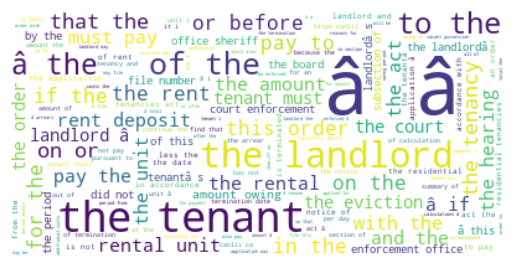

In [7]:
# annotated data wordcloud
tokens = ' '.join(text).lower()
wordcloud = WordCloud(
    background_color = 'white',
    # stopwords = stopwords
    stopwords = []
).generate(tokens)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Clean the Raw File Names to Match the Annotated Data

In [8]:
for file_name in os.listdir(text_path):
    file_no = file_name[:-4]
    txt = file_name[-4:]
    if ' and ' in file_no:
        # print(file_name)
        new_name = file_no.replace(' and ', ';') + txt
        os.rename(text_path+file_name, text_path+new_name)
        file_name = new_name
        file_no = file_name[:-4]
        # print(file_name)
    if '/' in file_no:
        # print(file_name)
        new_name = file_no.replace('//', ';') + txt
        os.rename(text_path+file_name, text_path+new_name)
        file_name = new_name
        file_no = file_name[:-4]
        # print(file_name)
    if ' ' in file_no:
        # print(file_name)
        new_name = file_no.replace(' ',';').strip(';') + txt
        os.rename(text_path+file_name, text_path+new_name)
        file_name = new_name
        file_no = file_name[:-4]
        # print(file_name)
    if ';' in file_no:
        # print(file_name)
        new_name = re.sub(REGEX, ';', file_no) + txt
        os.rename(text_path+file_name, text_path+new_name)
        file_name = new_name
        file_no = file_name[:-4]
        # print(file_name)
    if 'File;number:;' in file_no:
        new_name = file_n.replace('File;number:;', '') + txt
        os.rename(text_path+file_name, text_path+new_name)
        file_name = new_name
        file_no = file_name[:-4]     

In [9]:
for file_name in os.listdir(text_path):
    if ';' in file_name:
        print(file_name)

multiple_files;2.zip


In [10]:
# no need to scrape anymore
# file_no = df['What is the file number of the case?']

# canlii_search = 'https://www.canlii.org/en/#search/id='
# response = requests.get(canlii_search+file_no[0])
# soup = BeautifulSoup(response.content, 'html.parser')
# judge = soup.find_all('script')

In [11]:
df.columns   #`Timestamp` is not the time of the case

Index(['Timestamp', 'Email Address', 'What is the file number of the case?',
       'What was the date of the hearing? [mm/dd/yyyy]',
       'What was the date of the decision? [mm/dd/yyyy]',
       'Who was the member adjudicating the decision?',
       'What was the location of the landlord tenant board?',
       'Did the decision state the landlord was represented?',
       'Did the decision state the landlord attended the hearing?',
       'Did the decision state the tenant was represented?',
       'Did the decision state the tenant attended the hearing?',
       'Did the decision state the landlord was a not-for-profit landlord (e.g. Toronto Community Housing)?',
       'Did the decision state the tenant was collecting a subsidy?',
       'What was the outcome of the case?',
       'What was the length of the tenancy, or in other words, how long had the tenants lived at the residence in question? ',
       'What was the monthly rent?',
       'What was the amount of the rental de

In [12]:
info_lst = df.columns[2:]

### Identify and Supplement the Missing Cases

In [13]:
cases_info = []
passed_cases = []
for i in range(len(df)):
    cases_info.append({})
    answers = df.iloc[i,2:]
    # to complete the scraping function
    # text = scraping(file_no)
    file_no = answers[0]
    if not os.path.isfile(text_path+file_no+'.txt'):
        print(f'The case with file number "{file_no}" does not exist. Skipping...')
        passed_cases.append(file_no)
    else:
        with open (text_path+file_no+'.txt') as t:
            cases_info[-1]['text'] = t.read()
    for j in range(len(answers)):
        q = info_lst[j]
        a = answers[j]
        cases_info[-1][q] = a
print(passed_cases)
len(passed_cases)

The case with file number "TET-89650-18;TEL-90138-18" does not exist. Skipping...
The case with file number "TNL-00793-18;TNL-01183-18" does not exist. Skipping...
The case with file number "TNL-03299-18;TNT-00589-17" does not exist. Skipping...
The case with file number "TNL-04435-18;TNL-03907-18" does not exist. Skipping...
The case with file number "HOL-02144-17;HOT-02146-17" does not exist. Skipping...
The case with file number "TEL-87475-18;TET-86819-17;TET-88355-18" does not exist. Skipping...
The case with file number "SWL-08112-17;SWL-08113-17" does not exist. Skipping...
The case with file number "SWL-12547-18;SWL-12548-18" does not exist. Skipping...
The case with file number "SWL-13901-18;SWT-14627-18" does not exist. Skipping...
The case with file number "TEL-77442-17;TET-77790-17" does not exist. Skipping...
The case with file number "TEL-77505-17-RV;TEL-77505-17" does not exist. Skipping...
The case with file number "TNL-06025-18;TNL-06026-18" does not exist. Skipping...


16

In [14]:
sup_path = '../annotated_sup/'
if not os.path.exists(sup_path):
    os.makedirs(sup_path)
sup_urls = ['https://www.canlii.org/en/on/onltb/doc/2018/2018canlii113792/2018canlii113792.html?resultIndex=1',
            'https://www.canlii.org/en/on/onltb/doc/2018/2018canlii113807/2018canlii113807.html?resultIndex=1',
            'https://www.canlii.org/en/on/onltb/doc/2018/2018canlii111686/2018canlii111686.html?resultIndex=1',
            'https://www.canlii.org/en/on/onltb/doc/2018/2018canlii42485/2018canlii42485.html?resultIndex=1',
            'https://www.canlii.org/en/on/onltb/doc/2018/2018canlii88630/2018canlii88630.html?resultIndex=1',
            'https://www.canlii.org/en/on/onltb/doc/2019/2019canlii134569/2019canlii134569.html?resultIndex=1'          
           ]

In [15]:
from selenium import webdriver
sup_html_path = '../annotated_sup_html/'
if not os.path.exists(sup_html_path):
    os.makedirs(sup_html_path)
    
driver = webdriver.Chrome()
# Loop through the case IDs and URLs
for i, url in enumerate(sup_urls):
    # Generate a file name based on the case ID
    filename = f"case_{i}.html"
    if os.path.isfile(os.path.join(sup_html_path, filename)):
        print(filename, "already added, skipping...")
    else:
        # Navigate to the URL
        driver.get(url)

        # Get the page source
        html_content = driver.page_source

        # Save the HTML content to a file
        with open(os.path.join(sup_html_path, filename), "w", encoding="utf-8") as file:
            file.write(html_content)

        print(f"Saved HTML content for case ID {i}.")

# Close the WebDriver
driver.quit()

case_0.html already added, skipping...
case_1.html already added, skipping...
case_2.html already added, skipping...
case_3.html already added, skipping...
case_4.html already added, skipping...
case_5.html already added, skipping...


In [16]:
for file in os.listdir(sup_html_path):
    # print(sup_html_path + file)
    try:
        if os.path.isfile(sup_html_path + file) and not file.startswith('.'):
            print("Adding ", file, "...")
            with open(sup_html_path + file) as f:
                html = f.read()
            soup = BeautifulSoup(html, "html.parser")

            # find metadata
            document_meta = soup.find("div", {"id": "documentMeta"}) 
            meta_items = document_meta.find_all("div", {"class": "row py-1"})

            case_ID = ""
            meta_data = []
            for meta_item in meta_items:
                children_text = []
                for x in meta_item.findChildren()[:2]:
                    children_text.append(x.text)
                child_string = '\t'.join(children_text)
                if "file number" in child_string.lower():
                    case_ID = child_string.split("\t")[1].strip()
                    # print(case_ID)
                meta_data.append(child_string)

            # print(meta_data)
            # find text
            document_body = soup.find("div", {"class": "documentcontent"}).get_text()

            # write to file
            with open(sup_path + case_ID + '.txt', 'w') as file:
                file.write('Metadata:\n')
                file.write('\n'.join(meta_data))
                file.write('Content:\n')
                file.write(document_body)
    except:
        print("Error with:", file)

Adding  case_6.html ...
Adding  case_0.html ...
Adding  case_1.html ...
Adding  case_2.html ...
Adding  case_3.html ...
Adding  case_4.html ...
Adding  case_5.html ...


In [17]:
len(set(df['What is the file number of the case?']))

682

In [18]:
type(df['What is the file number of the case?'])

pandas.core.series.Series

### Remove the Duplicated Annotations

In [19]:
file_nums = list(df['What is the file number of the case?'])
dup = []
for i in range(len(file_nums)):
    if file_nums[i] in file_nums[:i]:
        dup.append(file_nums[i])
dup, len(dup)

(['CEL-90549-19',
  'CEL-90549-19',
  'SWL-17145-18',
  'TEL-85406-17',
  'CEL-77276-18',
  'TEL-94512-18',
  'CEL-87788-19',
  'HOL-02330-18',
  'HOL-02425-18-RV',
  'HOL-02707-18',
  'TEL-89165-18',
  'TEL-89446-18',
  'CEL-90549-19',
  'TEL-75638-16',
  'TEL-88533-18',
  'TEL-88767-18',
  'TEL-88799-18',
  'TEL-88801-18',
  'TSL-03695-19',
  'TSL-03695-19'],
 20)

### Add Raw File Texts and Raw File Names to the Dataframe

In [20]:
# Remove duplicate rows based on column 'A'
df_unique = df.drop_duplicates(subset=['What is the file number of the case?'])

In [21]:
multi_path = text_path + 'multiple_files/'
# This directory was created manually

In [22]:
info_lst = df_unique.columns[2:]

raw_file_text = []
cases_info = []
passed_cases = []
raw_file_name = []

for i in range(len(df_unique)):
    cases_info.append({})
    answers = df_unique.iloc[i,2:]
    # to complete the scraping function
    # text = scraping(file_no)
    file_no = answers[0]
    if not os.path.isfile(text_path+file_no+'.txt'):
        print(f'{file_no} not found. Going to the supplement directory.')
        # passed_cases.append(file_no)
        if not os.path.isfile(sup_path+file_no+'.txt'):
            print(f'{file_no} not found. Going to the multiple directory.')
            with open (multi_path+file_no+'.txt') as t:
                # print(t.read())
                # cases_info[-1]['text'] = t.read()
                raw_file_text.append(t.read())
                raw_file_name.append(file_no+'.txt')
        else:
            with open (sup_path+file_no+'.txt') as t:
                # cases_info[-1]['text'] = t.read()
                raw_file_text.append(t.read())
                raw_file_name.append(file_no+'.txt')
    else:
        with open (text_path+file_no+'.txt') as t:
            # cases_info[-1]['text'] = t.read()
            raw_file_text.append(t.read())
            raw_file_name.append(file_no+'.txt')
    for j in range(len(answers)):
        q = info_lst[j]
        a = answers[j]
        cases_info[-1][q] = a
print(len(raw_file_text), len(raw_file_name))

TET-89650-18;TEL-90138-18 not found. Going to the supplement directory.
TNL-00793-18;TNL-01183-18 not found. Going to the supplement directory.
TNL-00793-18;TNL-01183-18 not found. Going to the multiple directory.
TNL-03299-18;TNT-00589-17 not found. Going to the supplement directory.
TNL-03299-18;TNT-00589-17 not found. Going to the multiple directory.
TNL-04435-18;TNL-03907-18 not found. Going to the supplement directory.
HOL-02144-17;HOT-02146-17 not found. Going to the supplement directory.
TEL-87475-18;TET-86819-17;TET-88355-18 not found. Going to the supplement directory.
TEL-87475-18;TET-86819-17;TET-88355-18 not found. Going to the multiple directory.
SWL-08112-17;SWL-08113-17 not found. Going to the supplement directory.
SWL-12547-18;SWL-12548-18 not found. Going to the supplement directory.
SWL-12547-18;SWL-12548-18 not found. Going to the multiple directory.
SWL-13901-18;SWT-14627-18 not found. Going to the supplement directory.
TEL-77442-17;TET-77790-17 not found. Going to 

In [23]:
raw_file_text[0][:1000]

"Metadata:\nDate:\t2020-06-04\nFile number:\t\nCEL-87788-19\n\tCEL-87788-19\nCitation:\tCEL-87788-19 (Re), 2020 CanLII 61226 (ON LTB), <https://canlii.ca/t/j9dqj>, retrieved on 2023-05-15\thttps://canlii.ca/t/j9dqj\nContent:\n\n\nOrder under Section 69\nResidential Tenancies\nAct, 2006\n\xa0\nFile Number: CEL-87788-19\n\xa0\n\n\n\n\n\n\n\n\n\n\n\n\xa0\n\xa0\n\xa0\n\nM.C. (the 'Landlord') applied for an order to\nterminate the tenancy and evict M.K. (the 'Tenant') because he has been\npersistently late in paying his rent. The Landlord also claimed compensation\nfor each day the Tenant remained in the unit after the termination date.\n\xa0\nThis application was heard in Toronto on October 16,\n2019.\n\xa0\nThe Landlord and the Tenant\nattended the hearing. The Landlord was represented by S.K. \n\xa0\nAlso in attendance was the Landlord’s property manager,\nB.A. \n\xa0\nDeterminations:\n\xa0\n1.\xa0\xa0 \xa0\xa0\nBy way of background, this is\na month to month tenancy in which rent is due

In [24]:
df_unique['raw_file_text'] = raw_file_text
df_unique['raw_file_name'] = raw_file_name

/var/folders/qk/z8sxk5x56mx_814stxf4bx7c0000gn/T/ipykernel_64121/421566289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['raw_file_text'] = raw_file_text
/var/folders/qk/z8sxk5x56mx_814stxf4bx7c0000gn/T/ipykernel_64121/421566289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['raw_file_name'] = raw_file_name


In [25]:
print(df_unique.shape)
df_unique[:6]

(682, 56)


,Timestamp,Email Address,What is the file number of the case?,What was the date of the hearing? [mm/dd/yyyy],What was the date of the decision? [mm/dd/yyyy],Who was the member adjudicating the decision?,What was the location of the landlord tenant board?,Did the decision state the landlord was represented?,Did the decision state the landlord attended the hearing?,Did the decision state the tenant was represented?,...,Did the decision state the tenant was given prior notice for the eviction?,"If the tenant was given prior notice for the eviction, how much notice was given?",Did the decisions state postponement would result in the tenant accruing additional arrears?,Which other specific applications of the landlord or the tenant were mentioned?,Did the decision mention the validity of an N4 eviction notice?,Were there detail(s) in the decision not captured by this questionnaire that should be included?,Exec Review,Review Status,raw_file_text,raw_file_name
0,2020-11-18 00:31:40.706,dylan.juschko@mail.utoronto.ca,CEL-87788-19,2019-10-16 00:00:00,2020-06-04 00:00:00,Sonia Anwar-Ali,Toronto,Yes,NaN,No,...,No,NaN,No,L2: Application to End a Tenancy and Evict a T...,No,Tenant was a single mother with no support fro...,NaN,NaN,Metadata:\nDate:\t2020-06-04\nFile number:\t\n...,CEL-87788-19.txt
1,2020-11-18 19:26:29.581,dylan.juschko@mail.utoronto.ca,CEL-90549-19,2020-01-22 00:00:00,2020-01-10 00:00:00,Shelby Whittick,Mississauga,Yes,Yes,No,...,Yes,Not stated,Yes,No other specific applications were mentioned,No,NaN,AW,Complete,Metadata:\nDate:\t2020-01-10\nFile number:\t\n...,CEL-90549-19.txt
2,2020-12-24 09:19:21.479,kayly.machado@mail.utoronto.ca,TEL-94478-18,2018-10-31 00:00:00,2018-11-21 00:00:00,Ruth Carey (Vice Chair),Toronto,Yes,Yes,No,...,Yes,Not stated,No,N13: Notice to End your Tenancy Because the La...,No,Previous decision TEL-92736-18 < This decision...,AW,Complete,Metadata:\nDate:\t2018-11-21\nFile number:\t\n...,TEL-94478-18.txt
3,2020-12-24 06:13:17.400,kayly.machado@mail.utoronto.ca,TEL-94493-18,2018-10-31 00:00:00,2018-11-21 00:00:00,Ruth Carey (Vice Chair),Toronto,Yes,Yes,No,...,Yes,Not stated,No,No other specific applications were mentioned,No,There were 7 previous application for non-paym...,AW,Complete,Metadata:\nDate:\t2018-11-21\nFile number:\t\n...,TEL-94493-18.txt
4,2020-11-19 17:02:36.702,joseph.galinsky@mail.utoronto.ca,CEL-72994-18,2018-03-07 00:00:00,2018-03-14 00:00:00,Avril Cardoso,Mississauga,Yes,No,Yes,...,Yes,Not stated,No,No other specific applications were mentioned,No,Third Application by Landlord in past 6 months...,AW,Complete,Metadata:\nDate:\t2018-03-14\nFile number:\t\n...,CEL-72994-18.txt
5,2020-11-19 17:14:22.294,joseph.galinsky@mail.utoronto.ca,CEL-73021-18,2018-06-15 00:00:00,2018-06-18 00:00:00,Avril Cardoso,Mississauga,Yes,No,No,...,Yes,Not stated,No,L1: Application to Evict a Tenant for Non-paym...,No,Tenant did not show up because hearing took pl...,AW,Complete,Metadata:\nDate:\t2018-06-18\nFile number:\t\n...,CEL-73021-18.txt


### Print the Multiple-file Cases

In [26]:
for file in os.listdir(multi_path):
    print(file[:-4])

SWL-08112-17;SWL-08113-17
TNL-06025-18;TNL-06026-18
TSL-93207-18-RV;TST-94747-18;TSL-00082-18
.DS_S
CEL-72209-17;CET-73173-18
TNL-00793-18;TNL-01183-18
SWL-12547-18;SWL-12548-18
TET-89650-18;TEL-90138-18
TEL-77505-17-RV;TEL-77505-17
HOL-02144-17;HOT-02146-17
TNL-03299-18;TNT-00589-17
TEL-79519-17;TET-79366-17
TEL-77442-17;TET-77790-17
SWL-13901-18;SWT-14627-18
TNL-04435-18;TNL-03907-18
TEL-87475-18;TET-86819-17;TET-88355-18


## Create the CSV File of the Cleaned Unique Data

**The csv file can be read inappropriately because of the commas in the data, so this is only for reference.*

In [27]:
df_unique.to_csv('matched_data.csv', index=False)

## A Test before Fine-tuning

### Initialize the Tokenizer and the Model

In [28]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

model = AutoModelForCausalLM.from_pretrained("gpt2")

In [29]:
stop_words = [
    "a", "an", "and", "are", "as", "at", "be", "but", "by", "for", "if", "in",
    "into", "is", "it",# "no", "not",
    "of", "on", "or", "such", "that", "the",
    "their", "then", "there", "these", "they", "this", "to", "was", "will", "with",
    "about", "all", "also", "any", "can", "could", "do", "does", "from", "has",
    "have", "how", "however", "i", "if", "may", "might", "my", "need", "our",
    "should", "so", "some", "than", "their", "them", "there", "these", "thing",
    "things", "think", "us", "want", "way", "we", "what", "when", "where", "which",
    "who", "why", "would", "you",
    'canlii'
]

### Test the Output of GPT-2 before Fine-tuning

In [30]:
text = cases_info[55]['What is the file number of the case?']
with open (text_path+text+'.txt') as t:
    text = t.read()
text = text[text.find('Content:')+8:]
text = text.replace('\n', ' ')[:8000]
text = text.replace('\xa0', ' ')
text = text.replace('\t', ' ')
text = text.replace('   ', ' ').replace('  ', ' ').replace('  ', ' ').replace('  ', ' ')
# text
for word in stop_words:
    text = text.replace(' '+word+' ', ' ')[:5000]
# print(text)

In [31]:
len(text)

3398

In [32]:
toks = tokenizer(text)

In [33]:
toks.keys()

dict_keys(['input_ids', 'attention_mask'])

In [34]:
q1 = list(cases_info[55].keys())[0]
q2 = list(cases_info[55].keys())[1]

In [35]:
a1 = cases_info[55][q1]
a2 = cases_info[55][q1]
a1_toks = tokenizer(a1)
a2_toks = tokenizer(a2)

In [36]:
q1 = text + list(cases_info[0].keys())[0]
q2 = text + list(cases_info[0].keys())[1]
q1_toks = tokenizer(q1)
q2_toks = tokenizer(q2)

In [37]:
input_ids = torch.tensor([
    # q1_toks['input_ids'],
    q2_toks['input_ids']
])
attn_mask = torch.tensor([
    # q1_toks['attention_mask'],
    q2_toks['attention_mask']
])
label = torch.tensor([
    # a1_toks['input_ids'],
    a2_toks['input_ids']
])
tokenizer.pad_token_id = tokenizer.eos_token_id

In [38]:
out = model.generate(input_ids=input_ids, 
                     attention_mask=attn_mask, 
                     return_dict_in_generate=True, 
                     output_scores=False, 
                     max_length=1024,
                     temperature=0.5,
                     do_sample=True,
                     repetition_penalty=3.0,
                     top_k=10)
result = tokenizer.batch_decode(out["sequences"], skip_special_tokens=True)
result

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[' Order under Section 69 Residential Tenancies Act, 2006 File Number: TEL-84192-17      K.P.M. (the \'Landlord\') applied order terminate tenancy evict D.T. M. M. T. (the \'Tenants\') because Tenants did not pay rent Tenants owe. L1 application And The Landlord applied order terminate tenancy evict Tenants because been persistently late paying rent. The Landlord claimed compensation each day Tenants remained unit after termination date. L2 application This combined application heard Toronto January 31, 2018. The Landlord’s representative, C.K. Tenant D.T. attended hearing. It determined that: L1 application 1. The Tenants not paid $818.99 total rent Tenants were required pay period November 1, 2015 January 31, 2018. Because arrears, Landlord served Notice Termination. 2. The Tenants owe Landlord $190.00 cost filing application. 3. The total amount owing $1,008.99($818.99 + $190.00). 4. The Tenant hearing proposed pay $125.00 every month along monthly rent pay rent arrears. The Tenant 